In [1]:
#Mounting google and authenticating
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive

Mounted at /content/gdrive


In [2]:
!cp /mydrive/music\ project/X_spec.pickle ./
!cp /mydrive/music\ project/y_spec.pickle ./

In [3]:
#LOADING DATA
import pickle 
pickle_off = open("X_spec.pickle", 'rb')
X_spec = pickle.load(pickle_off)

pickle_off = open("y_spec.pickle", 'rb')
y_spec = pickle.load(pickle_off)

In [4]:
import numpy as np
dataset = np.vstack((X_spec,y_spec))
dataset = dataset.reshape(2862,300,128,1)

dataset.shape

(2862, 300, 128, 1)

In [66]:
test = dataset[:287]
train = dataset[287:]
print(train.shape)
print(test.shape)

(2575, 300, 128, 1)
(287, 300, 128, 1)


In [67]:
train.shape

(2575, 300, 128, 1)

In [68]:
# For visual
import matplotlib.pyplot as plt
import librosa
import librosa.display
import time
from IPython import display
import tensorflow as tf



In [69]:
#Normalization
train = train.astype('float32') /100
test = test.astype('float32') /100
train_size = 2575
batch_size = 32
test_size = 287

In [70]:
#Getting Data Ready
import tensorflow as tf

train_dataset = (tf.data.Dataset.from_tensor_slices(train)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test)
                .shuffle(test_size).batch(batch_size))

In [ ]:
#Test Encoding
x = tf.keras.layers.Input((300, 128, 1))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), padding='same', activation='relu')(x)
x.shape



TensorShape([None, 19, 8, 256])

In [ ]:
#Test Decoding
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(4,)))
model.add(tf.keras.layers.Dense(units=18*12*256, activation=tf.nn.relu))
model.add(tf.keras.layers.Reshape(target_shape=(18, 12, 256)))
model.add(tf.keras.layers.Conv2DTranspose(
                filters=256, kernel_size=3, strides=(2,1), 
                activation='relu'))
model.add(tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=(2,1),
                activation='relu'))
model.add(tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=(1,2), padding='same',
                activation='relu'))
model.add(tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'))
model.add(tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'))
model.add(tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same',))

model.output_shape

(None, 300, 128, 1)

In [ ]:
model.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 55296)             276480    
_________________________________________________________________
reshape_65 (Reshape)         (None, 18, 12, 256)       0         
_________________________________________________________________
conv2d_transpose_248 (Conv2D (None, 37, 14, 256)       590080    
_________________________________________________________________
conv2d_transpose_249 (Conv2D (None, 75, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_250 (Conv2D (None, 75, 32, 128)       147584    
_________________________________________________________________
conv2d_transpose_251 (Conv2D (None, 150, 64, 64)       73792     
_________________________________________________________________
conv2d_transpose_252 (Conv2D (None, 300, 128, 32)    

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(300, 128, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(1, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(2, 1), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=256, kernel_size=3, strides=(2, 1), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=18*12*256, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(18, 12, 256)),
            tf.keras.layers.Conv2DTranspose(
                filters=256, kernel_size=3, strides=(2,1), 
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=(2,1),
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=(1,2), padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 5
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 40
num_examples_to_generate = 1

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  test = test_sample.numpy()
  predictions = predictions.numpy() 
  predictions=predictions.reshape(1,300,128) 
  test=test.reshape(1,300,128) 
  print('test: ',type(test), test.max(), test.min(), test.shape)
  print('predictions: ',type(predictions), predictions.max(), predictions.min(), predictions.shape)


  genre_name = 'test'
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(test[0].T, y_axis='time', fmax=8000, x_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(str(genre_name))
  plt.show()

  genre_name = 'predict'
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(predictions[0].T, y_axis='time', fmax=8000, x_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(str(genre_name))
  plt.show()


In [ ]:
assert batch_size >= num_examples_to_generate

for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]
  print(test_sample.shape)

(1, 300, 128, 1)


In [ ]:
import time
from IPython import display

generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [37]:
from tensorflow.keras import layers
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(18*12*256, input_shape=(100,)))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((18, 12, 256)))
    ##assert model.output_shape == (None, 18, 12, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(2, 1) ))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 1) ))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 2), padding='same',))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same',))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same',))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same'))
    return model


In [41]:
generator = make_generator_model()

In [42]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[300, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [43]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-8.124212e-05]], shape=(1, 1), dtype=float32)


In [46]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [48]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [55]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 1
BATCH_SIZE=32

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [56]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [84]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed, test)

    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed, test)

In [87]:
def generate_and_save_images(model, epoch, test_input, test):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input) #, training=False
  predictions = predictions.numpy()
  predictions=predictions.reshape(1,300,128) * 100
  test=test[0].reshape(300,128) * 100
  print('test: ',type(test), test.max(), test.min(), test.shape)
  print('predictions: ',type(predictions), predictions.max(), predictions.min(), predictions.shape)

  genre_name = 'test'
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(test.T, y_axis='time', fmax=8000, x_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(str(genre_name))
  plt.show()
  fig = plt.figure(figsize=(4, 4))

  genre_name = 'predict'
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(predictions[0].T, y_axis='time', fmax=8000, x_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(str(genre_name))
  plt.show()


test:  <class 'numpy.ndarray'> 6.9396324 -73.06036 (300, 128)
predictions:  <class 'numpy.ndarray'> -10.829699 -158.87161 (1, 300, 128)


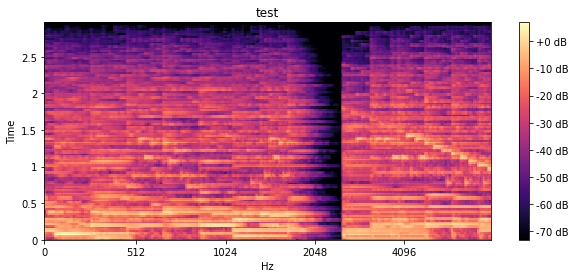

<Figure size 288x288 with 0 Axes>

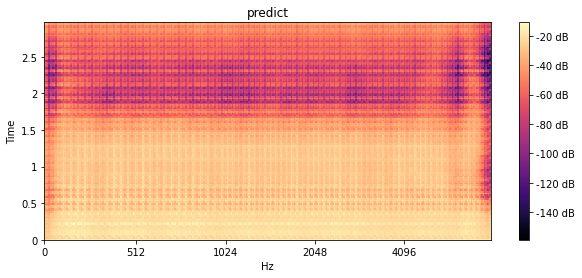

In [89]:
train(train_dataset, EPOCHS)


test:  <class 'numpy.ndarray'> 6.9396324 -73.06036 (300, 128)
predictions:  <class 'numpy.ndarray'> 1.6366608 -9.247601 (1, 300, 128)


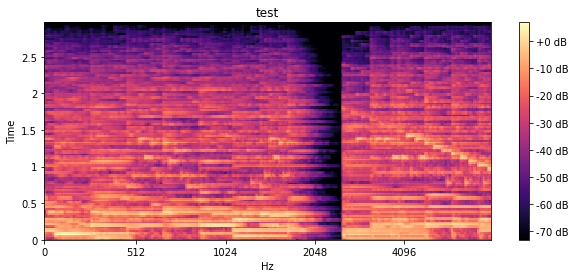

<Figure size 288x288 with 0 Axes>

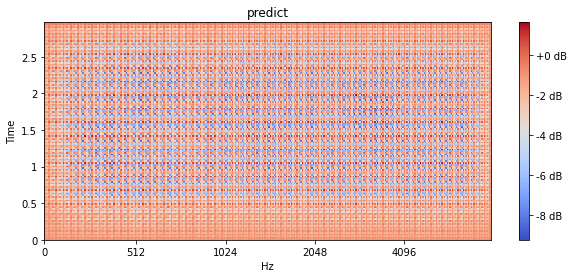

In [88]:
generate_and_save_images(generator, 1,seed, test)

In [78]:
type(test)

numpy.ndarray